In [44]:
include("main.jl")

In [18]:
test_image_path = "/Users/gurkansoykan/Desktop/ms-kuis20/projects/cloned-DLC-repo/examples/openfield-Pranav-2018-10-30/labeled-data/m4s1/img0000.png"
image_folder_path = "/Users/gurkansoykan/Desktop/ms-kuis20/projects/cloned-DLC-repo/examples/openfield-Pranav-2018-10-30/labeled-data/m4s1"
label_data_path = "/Users/gurkansoykan/Desktop/ms-kuis20/projects/cloned-DLC-repo/examples/openfield-Pranav-2018-10-30/labeled-data/m4s1/CollectedData_Pranav.csv"
image_dim_x = 640
image_dim_y = 480
number_of_categories = 4
minibatch_size = 16
test_set_size = 16
dev_set_size = 16

16

In [19]:
X, Y = read_all_data(label_data_path, image_dim_x, image_dim_y, number_of_categories)

(Float32[0.9019608 1.0 0.09803922; 0.9019608 0.0 0.09803922; … ; 1.0 0.09411765 0.19607843; 1.0 0.09803922 0.19607843]

Float32[0.27450982 0.28235295 0.27450982; 0.27450982 0.2784314 0.27450982; … ; 0.28235295 0.2784314 0.27450982; 0.28235295 0.27450982 0.27450982]

Float32[0.27058825 0.2784314 0.26666668; 0.27058825 0.2784314 0.26666668; … ; 0.2784314 0.2784314 0.27058825; 0.2784314 0.26666668 0.27058825]

...

Float32[0.101960786 0.101960786 0.101960786; 0.101960786 0.101960786 0.101960786; … ; 0.101960786 0.101960786 0.101960786; 0.101960786 0.101960786 0.101960786]

Float32[0.101960786 0.101960786 0.101960786; 0.101960786 0.105882354 0.101960786; … ; 0.101960786 0.101960786 0.105882354; 0.101960786 0.101960786 0.105882354]

Float32[0.101960786 0.101960786 0.101960786; 0.101960786 0.101960786 0.101960786; … ; 0.101960786 0.105882354 0.101960786; 0.101960786 0.101960786 0.101960786]

Float32[0.09411765 0.4 0.4; 0.09411765 0.09411765 0.4; … ; 0.4 0.7490196 0.7490196; 0.4 0.4 0.7490196

In [20]:
# TODO: improve this reshaping process
reshaped_X = reshape(X, (640, 480, 3, 116))
#reshaped_Y = reshape(Y, (640 * 480, 116 ))
reshaped_Y = reshape(Y, (8, 116 ))

x_train = reshaped_X[:,:,:, test_set_size + dev_set_size + 1 : end]
x_dev = reshaped_X[:,:,:, test_set_size + 1: test_set_size + dev_set_size]
x_test = reshaped_X[:,:,:, begin : test_set_size ]

y_train = reshaped_Y[:, test_set_size + dev_set_size + 1: end]
y_dev = reshaped_Y[:, test_set_size + 1 : test_set_size + dev_set_size]
y_test = reshaped_Y[:, begin : test_set_size ]

println(size(y_test))
println(size(y_dev))
println(size(y_train))

(8, 16)
(8, 16)
(8, 84)


In [21]:
dtrn = minibatch(x_train, y_train, minibatch_size; xsize = (image_dim_x, image_dim_y, 3, :))
dtst = dtrn

5-element Knet.Train20.Data{Tuple{Array{Float32,N} where N,Array{Float32,N} where N}}

In [22]:
struct Conv; w; b; f; p; end
(c::Conv)(x) = c.f.(pool(conv4(c.w, dropout(x,c.p)) .+ c.b))
Conv(w1::Int,w2::Int,cx::Int,cy::Int,f=relu;pdrop=0) = Conv(param(w1,w2,cx,cy), param0(1,1,cy,1), f, pdrop)

Conv

In [23]:
struct Dense; w; b; f; p; end
(d::Dense)(x) = d.f.(d.w * mat(dropout(x,d.p)) .+ d.b) # mat reshapes 4-D tensor to 2-D matrix so we can use matmul
Dense(i::Int,o::Int,f=relu;pdrop=0) = Dense(param(o,i), param0(o), f, pdrop)

Dense

In [24]:
# loss(w,x,y) = sumabs2(y - predict(w,x)) / size(y,2)
function loss(x,y) 
    sum(abs2, y - x) / size(y, 2)
end

loss (generic function with 1 method)

In [25]:
struct Chain
    layers
    Chain(layers...) = new(layers)
end
(c::Chain)(x) = (for l in c.layers; x = l(x); end; x)
(c::Chain)(x,y) = loss(c(x), y)
(c::Chain)(d::Knet.Data) = mean(c(x,y) for (x,y) in d)

In [26]:
lenet =   Chain(Conv(5,5,3,20), 
                Conv(5,5,20,50), 
                Dense(918450,100,pdrop=0.3), 
                Dense(100,8,sigm,pdrop=0.3))
summary.(l.w for l in lenet.layers)

4-element Array{String,1}:
 "5×5×3×20 Param{Array{Float32,4}}"
 "5×5×20×50 Param{Array{Float32,4}}"
 "100×918450 Param{Array{Float32,2}}"
 "8×100 Param{Array{Float32,2}}"

In [27]:
progress!(adam(lenet, ncycle(dtrn,1), lr=0.005))

┣████████████████████┫ [100.00%, 5/5, 00:43/00:43, 8.57s/i] 


In [28]:
lenet_losses = compute_loss_for_sets(lenet, [("train", x_train, y_train), ("dev", x_dev, y_dev), ("test", x_test, y_test)])
println(lenet_losses)

1.598914
0.13380325
0.45890108
Dict{Any,Any}("train-loss" => 1.598914f0,"dev-loss" => 0.13380325f0,"test-loss" => 0.45890108f0)


In [33]:
lenet_accuracies = compute_accuracy_for_sets(lenet, [("train", x_train, y_train), ("dev", x_dev, y_dev), ("test", x_test, y_test)])
println(lenet_accuracies)

Dict{Any,Any}("train-accuracy-mae" => 0.33493066f0,"test-accuracy-mae" => 0.19958472f0,"dev-accuracy-mae" => 0.11287144f0)


In [57]:
basic_net =   Chain(Conv(5,5,3,8), 
            Dense(605472,8,sigm,pdrop=0.1))
summary.(l.w for l in basic_net.layers)

2-element Array{String,1}:
 "5×5×3×8 Param{Array{Float32,4}}"
 "8×605472 Param{Array{Float32,2}}"

In [58]:
# https://github.com/denizyuret/Knet.jl/blob/master/tutorial/50.cnn.ipynb can also be checked for trainresults
function mytrain!(model, train_data, test_data,
                  period::Int=1, iters::Int=2, learning_rate=0.005) 
    total_progress_count = iters/period
    train_loss = []
    test_loss = []
    push!(test_loss,  model(test_data))
    push!(train_loss,  model(train_data))
    for (i, _) in enumerate(sgd((x, y) -> model(x, y), cycle(train_data), lr=learning_rate))
        current_iter = i
        if current_iter > iters 
            break
        end
        println("current iteration: $current_iter")
        if current_iter % period == 0 
            push!(test_loss,  model(test_data))
            push!(train_loss,  model(train_data))
        end
    end    
    return 0:period:iters, train_loss, test_loss
end



mytrain! (generic function with 4 methods)

In [59]:
#progress!(sgd(basic_net, ncycle(dtrn,1), lr=0.005))

current iteration: 1
current iteration: 2
current iteration: 3
current iteration: 4
current iteration: 5
current iteration: 6
current iteration: 7
current iteration: 8
current iteration: 9
current iteration: 10
 85.760627 seconds (71.10 k allocations: 64.857 GiB, 36.19% gc time)


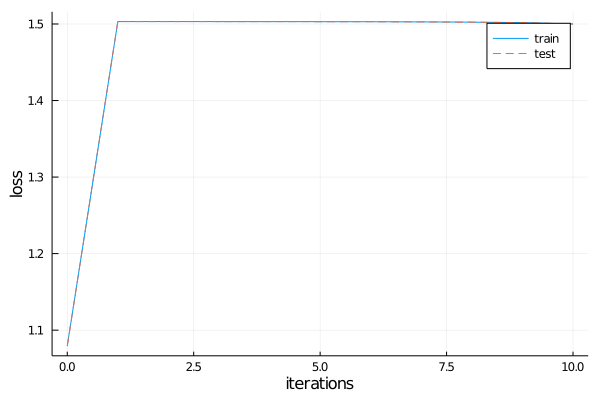

In [60]:
iters, trnloss, tstloss = @time mytrain!(basic_net, dtrn, dtst, 1, 10)
plot(iters, trnloss, label="train", xlabel="iterations", ylabel="loss")
plot!(iters, tstloss, label="test")

In [64]:
iters
trnloss

11-element Array{Any,1}:
 1.0792235f0
 1.5031886f0
 1.5031462f0
 1.5031174f0
 1.5030773f0
 1.503027f0
 1.502963f0
 1.5027243f0
 1.5024126f0
 1.5017515f0
 1.499986f0

In [61]:
basic_net_losses = @time compute_loss_for_sets(basic_net, [("train", x_train, y_train), ("dev", x_dev, y_dev), ("test", x_test, y_test)])
println(basic_net_losses)

  3.367919 seconds (8.46 k allocations: 2.871 GiB, 13.02% gc time)
Dict{Any,Any}("train-loss" => 1.4829623f0,"dev-loss" => 0.916476f0,"test-loss" => 0.91285855f0)


In [62]:
basic_net_accuracies = @time compute_accuracy_for_sets(basic_net, [("train", x_train, y_train), ("dev", x_dev, y_dev), ("test", x_test, y_test)])
println(basic_net_accuracies)

  3.044298 seconds (8.66 k allocations: 2.871 GiB, 6.05% gc time)
Dict{Any,Any}("train-accuracy-mae" => 0.32069594f0,"test-accuracy-mae" => 0.2557259f0,"dev-accuracy-mae" => 0.20895927f0)
